# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [54]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
train_path = "data/Train"
test_path = "data/Test"

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


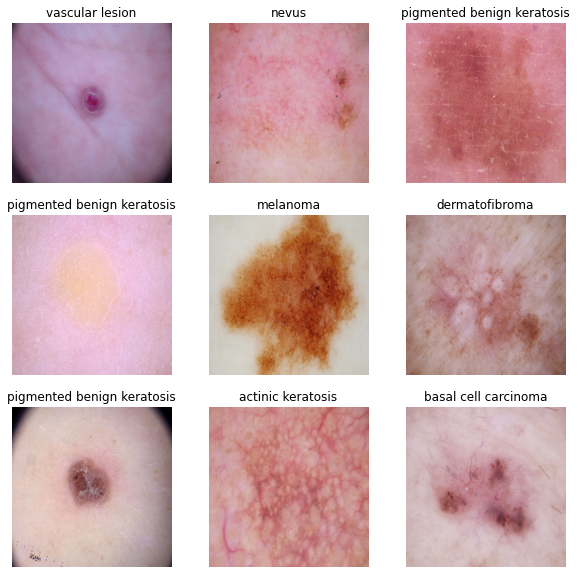

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
IMAGE_SIZE = [224,224]

In [5]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=2,
                                            class_mode='categorical')

Found 1981 images belonging to 7 classes.
Found 99 images belonging to 7 classes.


In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [26]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet50

In [75]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
x = Flatten()(resnet.output)

In [76]:
prediction = Dense(7, activation='softmax')(x)
model1 = Model(inputs = resnet.inputs, outputs = prediction)
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [77]:
model1.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=["accuracy",f1_m,precision_m, recall_m])

In [78]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
124/124 [==============================] - 45s 337ms/step - loss: 7.1565 - accuracy: 0.3831 - f1_m: 0.2785 - precision_m: 0.4552 - recall_m: 0.2104 - val_loss: 1.9416 - val_accuracy: 0.2332 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 41s 330ms/step - loss: 2.3599 - accuracy: 0.5013 - f1_m: 0.4046 - precision_m: 0.5664 - recall_m: 0.3205 - val_loss: 2.0430 - val_accuracy: 0.2332 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
124/124 [==============================] - 41s 331ms/step - loss: 2.3623 - accuracy: 0.5204 - f1_m: 0.4356 - precision_m: 0.5812 - recall_m: 0.3538 - val_loss: 2.0154 - val_accuracy: 0.2332 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
124/124 [==============================] - 41s 331ms/step - loss: 1.9981 - accuracy: 0.5477 - f1_m: 0.4912 - precision_m: 0.6540 - recall_m: 0.400

In [24]:
res_acc = hist1.history["val_accuracy"][19]
res_prec = hist1.history["val_precision_m"][19]
res_rec = hist1.history["val_recall_m"][19]
res_f1 = hist1.history["val_f1_m"][19]

In [27]:
storeResults('ResNet50',res_acc,res_prec,res_rec,res_f1)

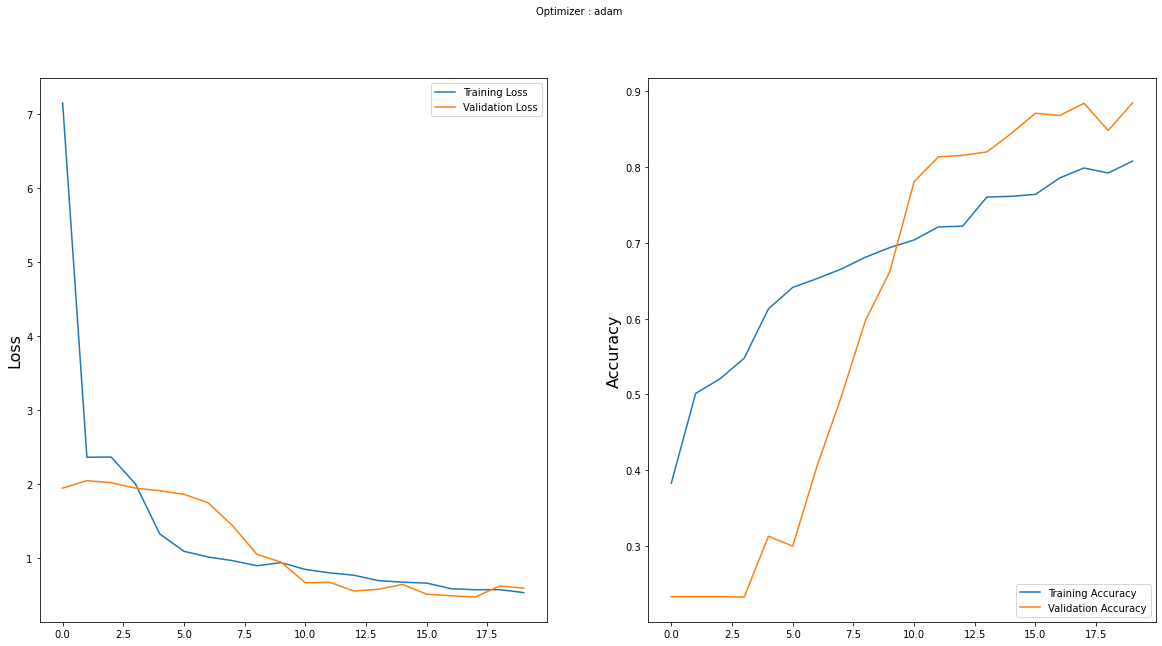

In [79]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet169

In [80]:
from tensorflow.keras.applications import DenseNet201, DenseNet169

In [81]:
des169=DenseNet169(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [82]:
x1= Flatten()(des169.output)
prediction1 = Dense(7, activation='softmax')(x1)
model2 = Model(inputs = des169.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [83]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
124/124 [==============================] - 79s 564ms/step - loss: 40.9290 - accuracy: 0.1898 - f1_m: 0.1887 - precision_m: 0.1918 - recall_m: 0.1868 - val_loss: 138081248.0000 - val_accuracy: 0.2352 - val_f1_m: 0.2355 - val_precision_m: 0.2355 - val_recall_m: 0.2355
Epoch 2/20
124/124 [==============================] - 121s 973ms/step - loss: 26.2242 - accuracy: 0.2393 - f1_m: 0.2359 - precision_m: 0.2374 - recall_m: 0.2348 - val_loss: 607.9746 - val_accuracy: 0.1767 - val_f1_m: 0.1754 - val_precision_m: 0.1763 - val_recall_m: 0.1745
Epoch 3/20
124/124 [==============================] - 133s 1s/step - loss: 12.4634 - accuracy: 0.2640 - f1_m: 0.2603 - precision_m: 0.2687 - recall_m: 0.2538 - val_loss: 146.5762 - val_accuracy: 0.2337 - val_f1_m: 0.2271 - val_precision_m: 0.2599 - val_recall_m: 0.2031
Epoch 4/20
124/124 [==============================] - 130s 1s/step - loss: 9.3084 - accuracy: 0.3024 - f1_m: 0.3000 - precision_m: 0.3162 - recall_m: 0.2884 - val_loss: 6.2047 - v

In [28]:
den_acc = hist2.history["val_accuracy"][19]
den_prec = hist2.history["val_precision_m"][19]
den_rec = hist2.history["val_recall_m"][19]
den_f1 = hist2.history["val_f1_m"][19]

In [29]:
storeResults('DenseNet169',den_acc,den_prec,den_rec,den_f1)

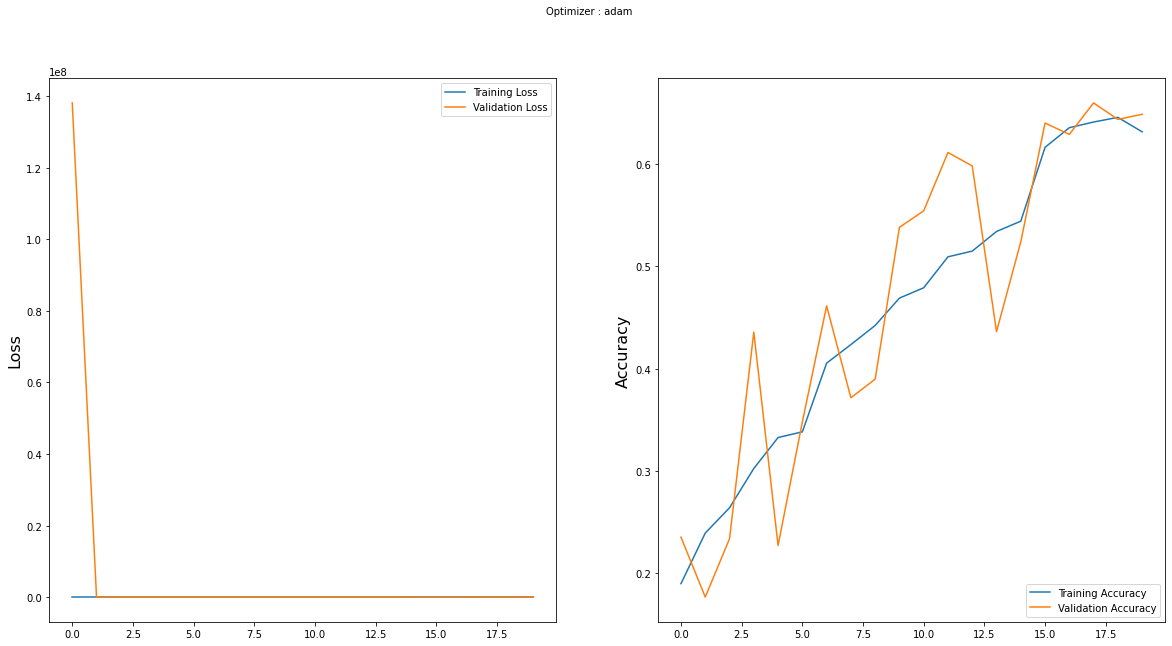

In [84]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# VGG16

In [21]:
vgg16=VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [22]:
x1= Flatten()(vgg16.output)
prediction1 = Dense(7, activation='softmax')(x1)
model3 = Model(inputs = vgg16.inputs, outputs = prediction1)
model3.summary()
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
991/991 [==============================] - 32s 31ms/step - loss: 2.1062 - accuracy: 0.2171 - f1_m: 0.0081 - precision_m: 0.0081 - recall_m: 0.0081 - val_loss: 2.3913 - val_accuracy: 0.1616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
991/991 [==============================] - 30s 30ms/step - loss: 1.8020 - accuracy: 0.2105 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.0072 - val_accuracy: 0.1616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
991/991 [==============================] - 30s 30ms/step - loss: 1.8537 - accuracy: 0.2302 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9618 - val_accuracy: 0.1616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
991/991 [==============================] - 30s 30ms/step - loss: 1.8156 - accuracy: 0.2332 - f1_m: 0.0000e+00 - precision_m: 

In [30]:
vgg_acc = hist3.history["val_accuracy"][9]
vgg_prec = hist3.history["val_precision_m"][9]
vgg_rec = hist3.history["val_recall_m"][9]
vgg_f1 = hist3.history["val_f1_m"][9]

In [31]:
storeResults('VGG16',vgg_acc,vgg_prec,vgg_rec,vgg_f1)

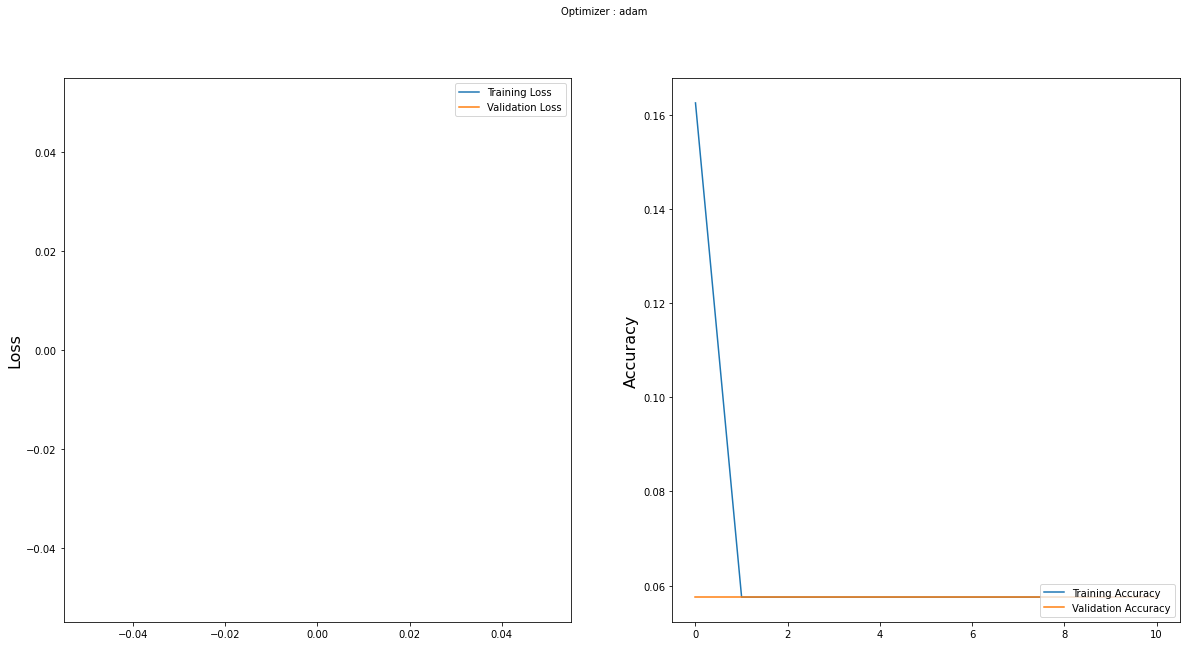

In [88]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet201

In [89]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [90]:
x1= Flatten()(des201.output)
prediction1 = Dense(7, activation='softmax')(x1)
model4 = Model(inputs = des201.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [91]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
124/124 [==============================] - 222s 2s/step - loss: 9.3184 - accuracy: 0.3140 - f1_m: 0.2933 - precision_m: 0.3409 - recall_m: 0.2665 - val_loss: 26052196.0000 - val_accuracy: 0.2211 - val_f1_m: 0.2211 - val_precision_m: 0.2211 - val_recall_m: 0.2211
Epoch 2/20
124/124 [==============================] - 158s 1s/step - loss: 9.5974 - accuracy: 0.3564 - f1_m: 0.3516 - precision_m: 0.3977 - recall_m: 0.3209 - val_loss: 30.3285 - val_accuracy: 0.1959 - val_f1_m: 0.1952 - val_precision_m: 0.1976 - val_recall_m: 0.1931
Epoch 3/20
124/124 [==============================] - 183s 1s/step - loss: 5.4426 - accuracy: 0.3781 - f1_m: 0.3692 - precision_m: 0.4099 - recall_m: 0.3408 - val_loss: 2.1991 - val_accuracy: 0.3372 - val_f1_m: 0.3082 - val_precision_m: 0.4307 - val_recall_m: 0.2437
Epoch 4/20
124/124 [==============================] - 178s 1s/step - loss: 5.3583 - accuracy: 0.3831 - f1_m: 0.3705 - precision_m: 0.4078 - recall_m: 0.3447 - val_loss: 13.1861 - val_accuracy

In [32]:
den2_acc = hist4.history["val_accuracy"][19]
den2_prec = hist4.history["val_precision_m"][19]
den2_rec = hist4.history["val_recall_m"][19]
den2_f1 = hist4.history["val_f1_m"][19]

In [33]:
storeResults('DenseNet201',den2_acc,den2_prec,den2_rec,den2_f1)

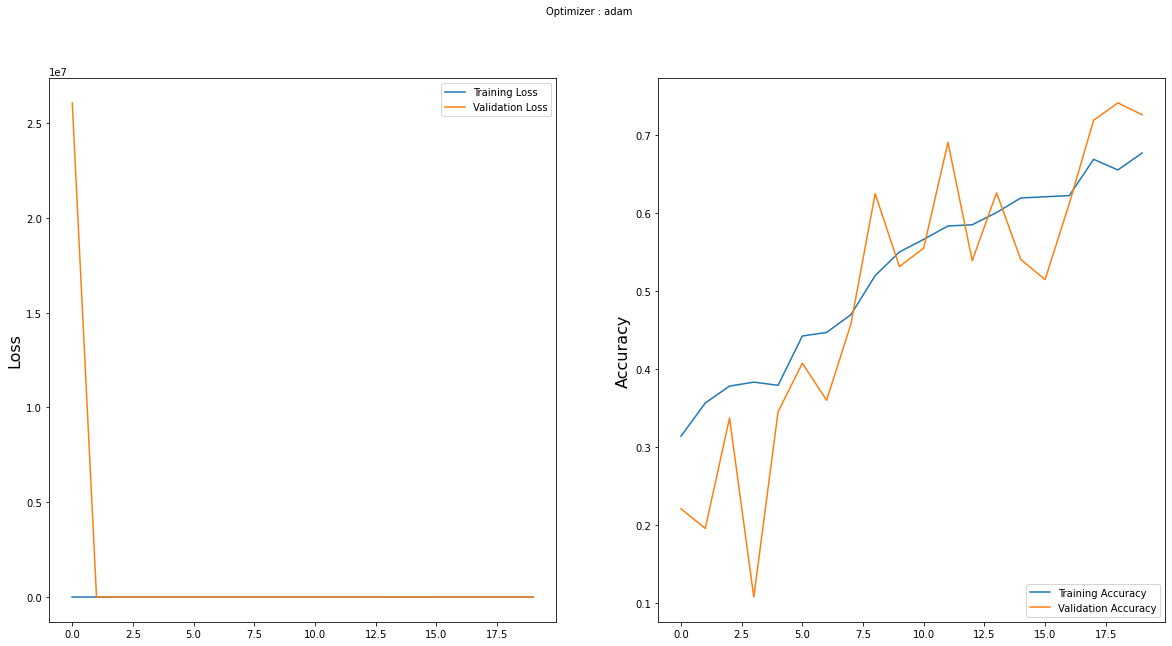

In [92]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [10]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(7, activation='softmax')(x)
# Combining base and head 
model5 = Model(inputs=base.input, outputs=head)

In [11]:
model5.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [12]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/20
124/124 [==============================] - 47s 332ms/step - loss: 1.6583 - accuracy: 0.3811 - f1_m: 0.0214 - precision_m: 0.1532 - recall_m: 0.0116 - val_loss: 1.4921 - val_accuracy: 0.4437 - val_f1_m: 0.1722 - val_precision_m: 0.6694 - val_recall_m: 0.1014
Epoch 2/20
124/124 [==============================] - 40s 321ms/step - loss: 1.2998 - accuracy: 0.5568 - f1_m: 0.2852 - precision_m: 0.8029 - recall_m: 0.1827 - val_loss: 1.0685 - val_accuracy: 0.6184 - val_f1_m: 0.5432 - val_precision_m: 0.8117 - val_recall_m: 0.4194
Epoch 3/20
124/124 [==============================] - 40s 322ms/step - loss: 0.9984 - accuracy: 0.6608 - f1_m: 0.5737 - precision_m: 0.8269 - recall_m: 0.4470 - val_loss: 0.7824 - val_accuracy: 0.7224 - val_f1_m: 0.6905 - val_precision_m: 0.8482 - val_recall_m: 0.5908
Epoch 4/20
124/124 [==============================] - 40s 320ms/step - loss: 0.8139 - accuracy: 0.7123 - f1_m: 0.6783 - precision_m: 0.8458 - recall_m: 0.5727 - val_loss: 0.5986 - val_accuracy:

In [34]:
xec_acc = hist5.history["val_accuracy"][19]
xec_prec = hist5.history["val_precision_m"][19]
xec_rec = hist5.history["val_recall_m"][19]
xec_f1 = hist5.history["val_f1_m"][19]

In [35]:
storeResults('Xception',xec_acc,xec_prec,xec_rec,xec_f1)

In [14]:
model5.save('model.h5')

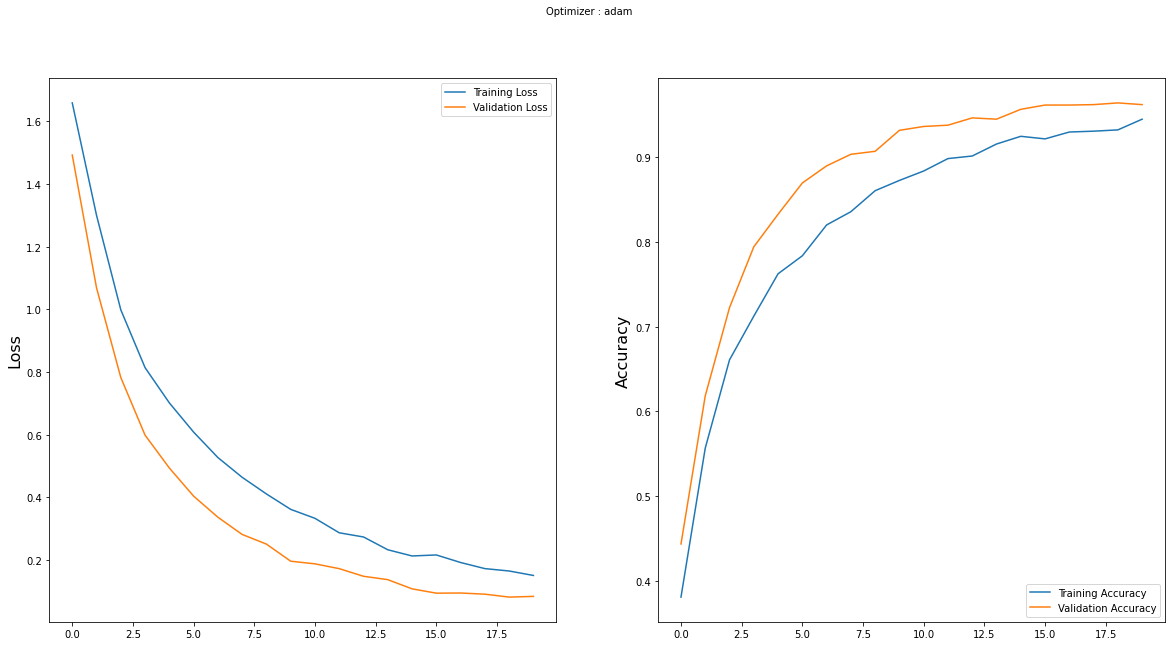

In [15]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [36]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                        
                        
                      })

In [37]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResNet50,0.884,0.876,0.909,0.847
1,DenseNet169,0.649,0.629,0.728,0.558
2,VGG16,0.233,0.000,0.000,0.000
3,DenseNet201,0.725,0.765,0.672,0.714
4,Xception,0.962,0.969,0.957,0.963


# Graph

In [38]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

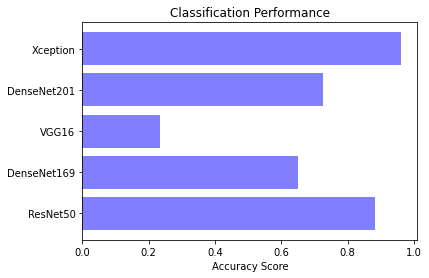

In [39]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

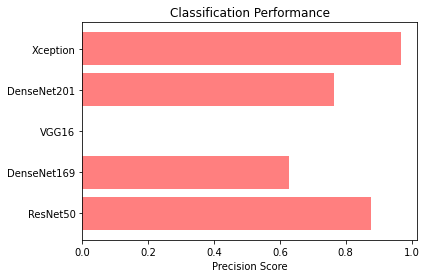

In [40]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

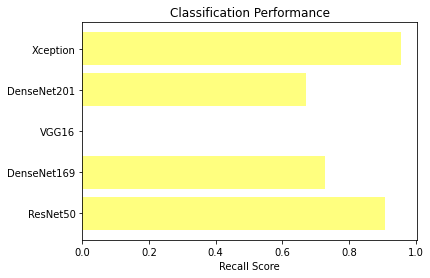

In [41]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1SCore

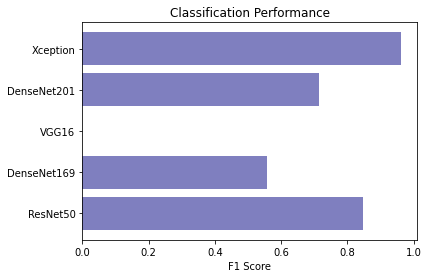

In [43]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()